# Predicting Recidivism Within 3 Years of Parolees from Georgia State

Authors: Mohammad Haroon, Yuliana Morales-Galvan, and Diego Zavala

## Introduction

Recidivism is calculated by criminal behavior including rearrest, reconviction or incarceration after a certain period a person has been released. In the State of Georgia recidivism is measured as a fingerprintable arrest recorded in Georgia Crime Information Center (GCIC) for a new felony or misdemeanor offenses within 3 years of parole supervision. In this report, we will use machine learning techniques to predict the likelihood of a parolee committing recidivism within 3 years.

This data comes from the National Institute of Justice (NIJ). It contains the information of prisoners released to parole in the state of Georgia from January 1st, 2013 to December 31st, 2015. There are 18000 rows of data, and each row of the data represents a different parolee. Some of the main variables in the data set include gender, race, gang affiliation, supervision risk score, and age at release.

Original Data URL: https://data.ojp.usdoj.gov/Corrections/NIJ-s-Recidivism-Challenge-Training-Dataset/8tjc-3ibv/about_data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import mode
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
import graphviz
from sklearn.tree import export_graphviz
from sklearn.preprocessing import PolynomialFeatures

Plotting Settings

In [2]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = 6,4

## Reading Data

In [3]:
input_file = "https://raw.githubusercontent.com/haroon73/project2/main/NIJ_s_Recidivism_Challenge_Training_Dataset_20240502.csv"
df = pd.read_csv(input_file)

## Data Preprocessing

Here's the summary of missing values across the dataset

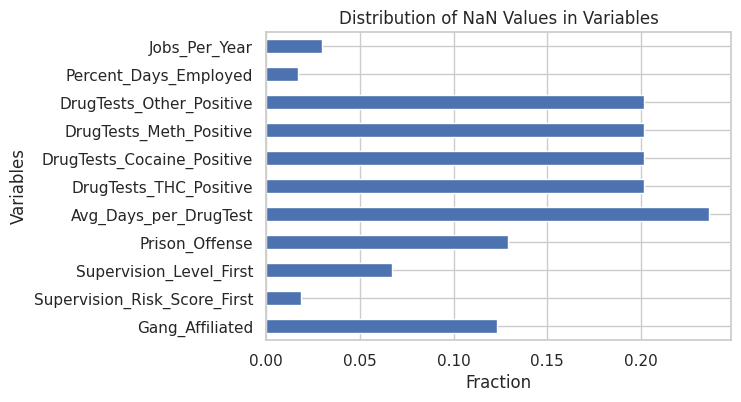

In [4]:
var_nan = df.isna().mean()
var_nan = var_nan[var_nan > 0]
var_nan.plot.barh()
plt.title('Distribution of NaN Values in Variables')
plt.xlabel('Fraction')
plt.ylabel('Variables');

The bar plot shows a group of variables that include DrugTests_Other_Positive, DrugTests_Meth_Positive, DrugTests_Cocaine_Positive, and DrugTests_THC_Positive to have around the same fraction of NAN values which is around 0.20. The variable Avg_Days_per_DrugTest appears to have the highest fraction of NAN values with the fraction being approximately greater than 0.25.

Overall, missing data is present across several columns in the dataset, which may need imputation or removal depending on the significance of the features and the impact on the model.

Dropping Columns with Significant Missing Values

In [5]:
df.drop(columns=['Avg_Days_per_DrugTest' , 'DrugTests_THC_Positive' , 'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive' ,'DrugTests_Other_Positive'], inplace=True)

There are a considerable number of missing values, ranging from 3632 to 4260. Given the significant amount of missing data, it might not be feasible to impute or fill in these missing values efficiently. Therefore, dropping these columns from the dataset could be a reasonable decision to ensure data integrity and avoid potential bias or misleading model results.


Filling missing values in column with the median value

In [6]:
df['Gang_Affiliated'].fillna(df['Gang_Affiliated'].median(), inplace=True)

we're filling the missing values in the 'Gang_Affiliated' column with the median value. This helps maintain the integrity of the data while addressing missing values.

Filling missing or NaN values with median.

In [7]:
df['Supervision_Risk_Score_First'].fillna(df['Supervision_Risk_Score_First'].median(), inplace=True)

The missing values in the Supervision_Risk_Score_First column are filled with the median value of the column. This approach helps maintain the central tendency of the data while addressing the missing values.

Filling missing or NaN values with Not

In [8]:
df['Supervision_Level_First'].fillna('Not', inplace=True)


By filling NaN values with 'Not', we maintain transparency regarding the absence of supervision-level information for these instances. This approach ensures that these missing values are distinct from the actual categories of 'Standard', 'Specialized', or 'High', and allows for the appropriate handling of missing data during analysis without losing valuable information.


Handling missing values in Prison_Offense.

In [9]:
df['Prison_Offense'].fillna('Unknown', inplace=True)

By replacing NaN values with 'Unknown', we preserve transparency about the absence of specific offense information while ensuring that the data remains usable for analysis. This approach was preferred to provide a clear indication that the offense information for these instances is not specified or unavailable.

## Data Exploration & Visualization

Summary of DataFrame Information

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 48 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 18028 non-null  int64  
 1   Gender                                             18028 non-null  object 
 2   Race                                               18028 non-null  object 
 3   Age_at_Release                                     18028 non-null  object 
 4   Residence_PUMA                                     18028 non-null  int64  
 5   Gang_Affiliated                                    18028 non-null  object 
 6   Supervision_Risk_Score_First                       18028 non-null  float64
 7   Supervision_Level_First                            18028 non-null  object 
 8   Education_Level                                    18028 non-null  object 
 9   Depend

This summary provides information about the DataFrame structure and data types. It indicates that the DataFrame contains 18028 entries and 48 columns. For each column, it displays the column name, the number of non-null values, and the data type. The data types include integers, floats, booleans, and objects (which typically represent strings or mixed types). Additionally, it shows the memory usage of the DataFrame. From this summary, you can assess the completeness of the data, understand the types of features available, and identify any potential data type issues.

Here are the variable names with their appropriate description

| Variable  | Meaning |
|--------|----------|
| ID  | Parolee Id        |
| Gender |           Indicates gender of parolee, Male or Female |
| Race | Parolee's race (Black or White)        |
| Age_at_Release  | Age of parolee when released. Ranging from 1: 18-22, 2:23-27, 3:28-32, 4:33-37, 5:38-42, 6:43-47, 7:48 or more        |
| Residence_PUMA  | Residence US Census Bureau Puma Group at prison release        |
| Gang_Affiliated  | Indicates if parolee is affiliated in gangs (1.0 true and 0.0 for false)        |
| Supervision_Risk_Score_First  | Assessment score (1-10, 10 highest risk)      |
| Supervision_Level_First  | Details the level of supervision Assignment (standard, high, specialized)       |
| Education_Level  | Indicates the level of education of parolee. Ranging from high school diploma to college        |
| Dependents  | Number of dependents of the parolee at prison entry       |
| Prison_Offense  | First Prison conviction offense group (violent/non-sex, violent/sex, property, drug,other)       |
| Prison_Years  | Number of years in prison before parole release       |
| Prior_Arrest_Episodes_Felony  | Number of prior arrest with a felony charge       |
| Prior_Arrest_Episodes_Misd  | Number of prior arrests with a  misdemeanor charge        |
| Prior_Arrest_Episodes_Violent  | Number of prior arrests with a violent charge       |
| Prior_Arrest_Episodes_Property  | Number of prior arrests that involve property         |
| Prior_Arrest_Episodes_Drug  | Number of prior arrests that involve drugs        |
| Prior_Arrest_Episodes_PPViolationCharges  | Number of prior arrests involving violation of probation and/or parole charges        |
| Prior_Arrest_Episodes_DVCharges  | Prior arrests that involve domestic violence. (True/False)       |
| Prior_Arrest_Episodes_GunCharges  | Prior arrests that involve gun charges. (True/False)       |
| Prior_Conviction_Episodes_Felony  | Number of prior convictions with a  felony charge       |
| Prior_Conviction_Episodes_Misd  | Number of prior convictions with  a misdemeanor charge       |
| Prior_Conviction_Episodes_Viol  | Prior convictions with a violent charge. (True/False)       |
| Prior_Conviction_Episodes_Prop  | Number of prior convictions with a property charge       |
| Prior_Conviction_Episodes_Drug  | Number of prior convictions with a drug charge        |
| Prior_Conviction_Episodes_PPViolationCharges  | Prior convictions with probation or parole violation charge.(True/False)        |
| Prior_Conviction_Episodes_DomesticViolenceCharges  | Prior convictions with a domestic violence charge.(True/False)       |
| Prior_Conviction_Episodes_GunCharges  | Prior convictions with a gun charge.(True/False)        |
| Prior_Revocations_Parole  | Prior Parole revocation (violating conditions of their parole).(True/False)        |
| Prior_Revocations_Probation  | Prior Probation revocations (violating conditions of probationary sentence).(True/False)        |
| Condition_MH_SA  | Mental Health or substance abuse condition at parole release.(True/False)       |
| Condition_Cog_Ed  | Parole release cognitive skills or education condition. (True/False)         |
| Condition_Other  | Parole release condition. (sex offender registration/no victim contact/ electronic monitoring).(True/False)        |
| Violations_ElectronicMonitoring  | Parolee violation of electronic monitoring.(True/False)        |
| Violations_Instruction  | Parolee not following instruction. (True/False)        |
| Violations_FailToReport  | Parolee failing to report.(True/False)        |
| Violations_MoveWithoutPermission  | Parolee moving without permission. (True/False)        |
| Delinquency_Reports  | Number of delinquency reports        |
| Program_Attendances  | Number of program attendances made by parolee       |
| Program_UnexcusedAbsences  | Number Parolee failed to attend mandatory program        |
| Residence_Changes  | Number of time residence of parolee changes        |
| Percent_Days_Employed  | Percent of days employed during parole       |
| Jobs_Per_Year  | Jobs parolee had per year        |
| Employment_Exempt  | employment not required (True/False)       |
| Recidivism_Within_3years  | Parolee relapse in behavior within 3 years (True/False)       |
| Recidivism_Arrest_Year1  | Parolee arrested during year one (True/False)       |
| Recidivism_Arrest_Year2  | Parolee arrested during year two (True/False)       |
| Recidivism_Arrest_Year3  | Parolee arrested during year three (True/False)       |

Let's begin to look at some of the important variables from the dataset, starting with the variable we will be trying to predict.

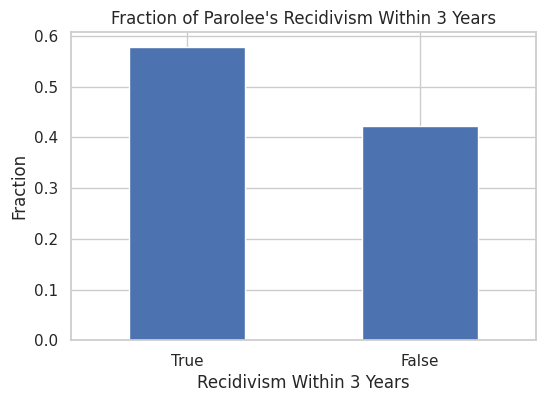

In [11]:
df['Recidivism_Within_3years'].value_counts(normalize=True).plot.bar(rot=0, title="Fraction of Parolee's Recidivism Within 3 Years")
plt.xlabel("Recidivism Within 3 Years")
plt.ylabel("Fraction");

This shows that 58% of the parolees, which accounts for 10421 people, in the data have been reconvicted within 3 years.

Let's review the recidivism arrest rates for the first year

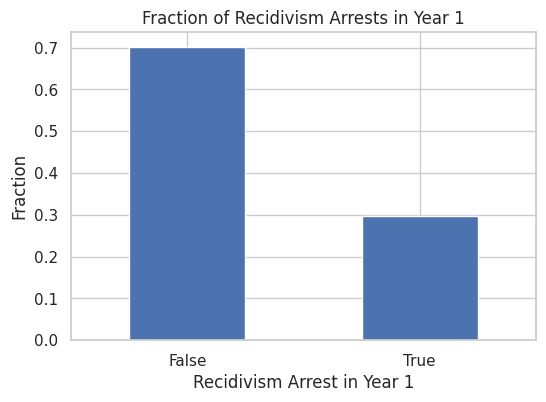

In [12]:
df['Recidivism_Arrest_Year1'].value_counts(normalize=True).plot.bar(rot=0, title="Fraction of Recidivism Arrests in Year 1")
plt.xlabel("Recidivism Arrest in Year 1")
plt.ylabel("Fraction");

The plot reveals that only 30% of arrests occurred within the first year of recidivism, compared to 58% within three years.

Let's examine the recidivism arrest rates for the second year.

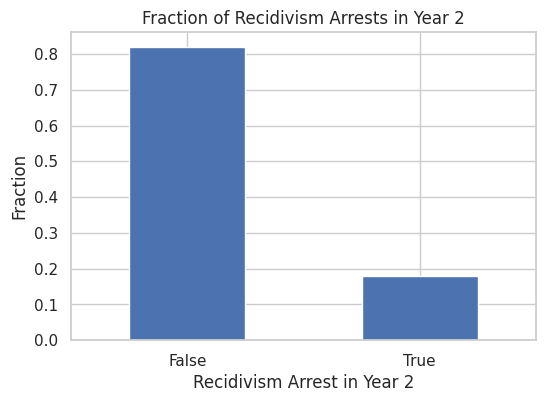

In [13]:
df['Recidivism_Arrest_Year2'].value_counts(normalize=True).plot.bar(rot=0, title="Fraction of Recidivism Arrests in Year 2")
plt.xlabel("Recidivism Arrest in Year 2")
plt.ylabel("Fraction");

The plot suggests that only 18% of arrests occurred during the second year of recidivism.

Let's examine the recidivism arrest rates for the third year.

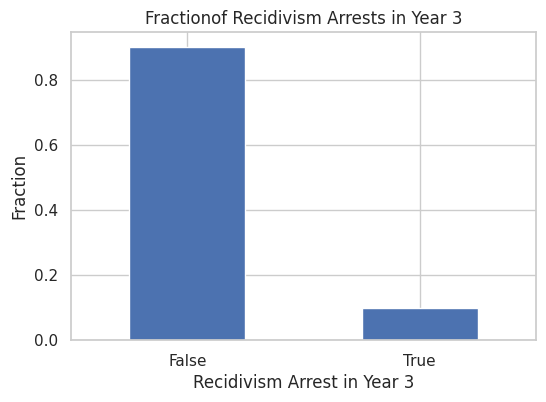

In [14]:
df['Recidivism_Arrest_Year3'].value_counts(normalize=True).plot.bar(rot=0, title="Fractionof Recidivism Arrests in Year 3")
plt.xlabel("Recidivism Arrest in Year 3")
plt.ylabel("Fraction");

The plot illustrates that only 7% of arrests occurred within the third year of recidivism, a notably lower rate compared to arrests during the first and second years of recidivism.

Now let's calculate the percentage of individuals affiliated with a gang out of the total population in the dataset.

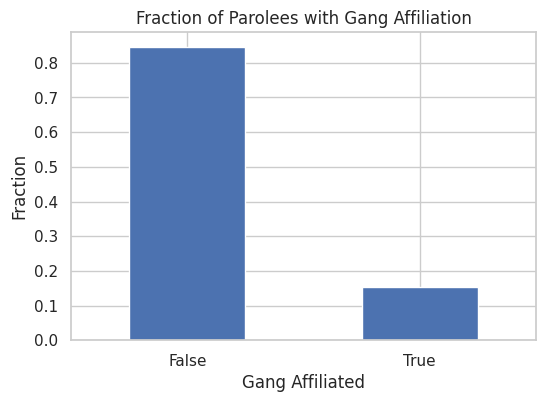

In [15]:
df['Gang_Affiliated'].value_counts(normalize=True).plot.bar(rot=0, title="Fraction of Parolees with Gang Affiliation")
plt.xlabel("Gang Affiliated")
plt.ylabel("Fraction");

This shows that only around 15% of the parolees are gang affiliated which does not account for many.  

Since we know that not many of the parolees are gang affiliated it is important to see the fraction of recidivism within 3 years by gang affiliation.

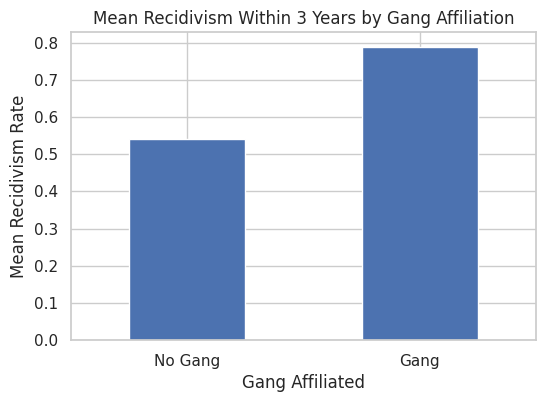

In [16]:
df.groupby('Gang_Affiliated')['Recidivism_Within_3years'].mean().plot.bar(rot=0)
plt.title('Mean Recidivism Within 3 Years by Gang Affiliation')
plt.xlabel('Gang Affiliated')
plt.ylabel('Mean Recidivism Rate')
plt.xticks([0, 1], ['No Gang', 'Gang']);

This bar plot illustrates the average rate of recidivism within three years among gang-affiliated and non-gang-affiliated individuals. As depicted, the mean recidivism rate is higher for gang-affiliated individuals even though they accounted for a smaller amount of the total parolees.

Knowing the recidivism rate within 3 years of the different races in the data set is also important because it can provide valuable information on whether a black or white person has a higher chance of being reconvicted within 3 years.

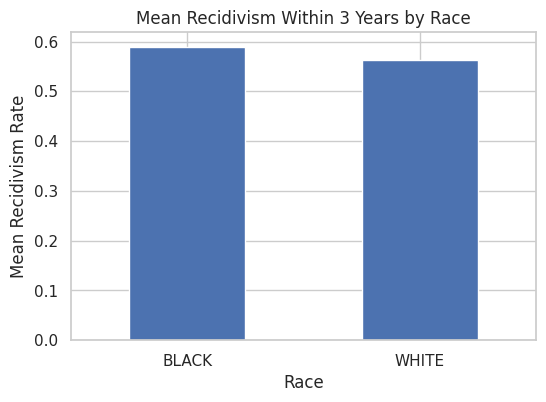

In [17]:
df.groupby('Race')['Recidivism_Within_3years'].mean().plot.bar(rot=0)
plt.title('Mean Recidivism Within 3 Years by Race')
plt.xlabel('Race')
plt.ylabel('Mean Recidivism Rate');

This plot shows that black and white parolees have nearly the same fraction of recidivism rate within 3 years with black having around 0.58 rate and white having around 0.56 rate.

Someone's prison offense can also be an important indicator of whether they will be reconvicted within 3 years. Below we will show the recidivism rate within 3 years by different prison offenses.

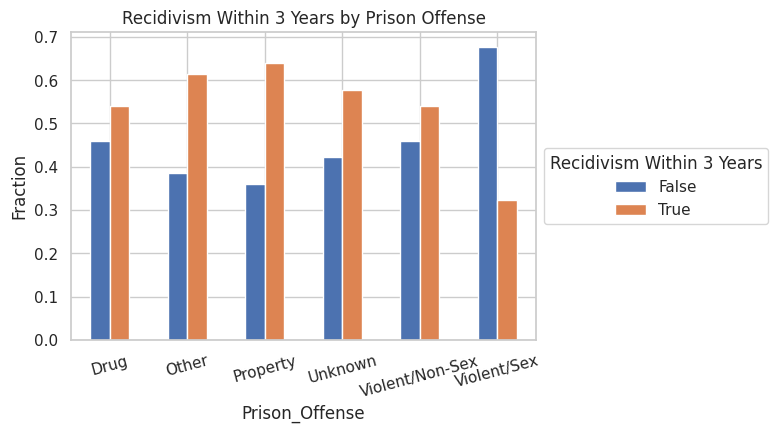

In [18]:
pd.crosstab(df['Prison_Offense'], df['Recidivism_Within_3years'],  normalize='index').plot.bar(rot = 15)
plt.title('Recidivism Within 3 Years by Prison Offense')
plt.ylabel('Fraction');
plt.legend(loc='center left', bbox_to_anchor = (1,0.5), title="Recidivism Within 3 Years");

This bar plot shows the distribution of recidivism within three years across different prison offense categories. Notably, the property offenses have the highest fraction of True values followed by other offenses and drug offenses. This indicates a higher rate of recidivism within this category while the violent/sex offenses have the lowest fraction which indicates lower rate of recidivism within 3 years.

We can also look at a parolee's number of arrests related to drug offenses since drug prison offense has one of the higher rates of recidivism within 3 years as shown in the previous plot.

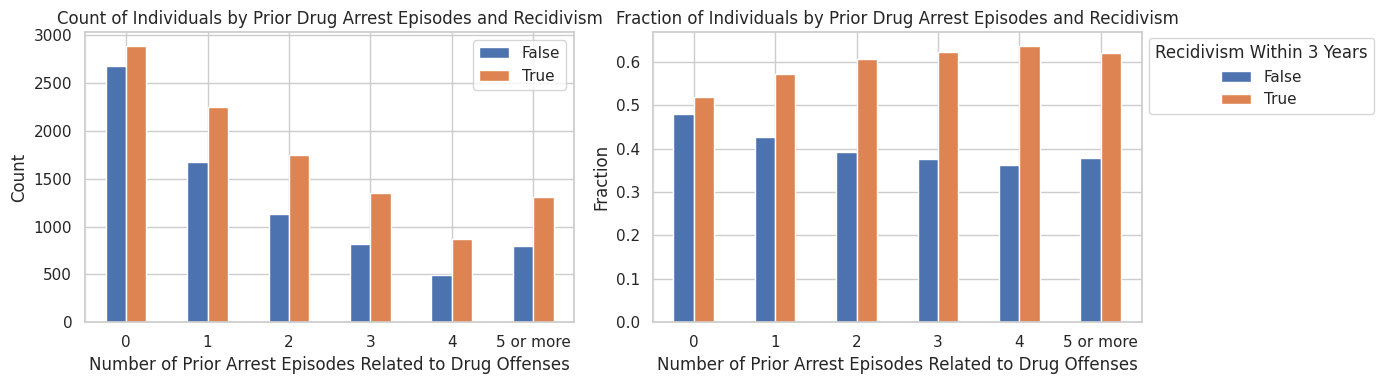

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

pd.crosstab(df['Prior_Arrest_Episodes_Drug'], df['Recidivism_Within_3years']).plot.bar(rot=0, ax=axs[0])
axs[0].set_title('Count of Individuals by Prior Drug Arrest Episodes and Recidivism')
axs[0].set_xlabel('Number of Prior Arrest Episodes Related to Drug Offenses')
axs[0].set_ylabel('Count')
axs[0].legend()
pd.crosstab(df['Prior_Arrest_Episodes_Drug'], df['Recidivism_Within_3years'], normalize='index').plot.bar(rot=0, ax=axs[1])
axs[1].set_title('Fraction of Individuals by Prior Drug Arrest Episodes and Recidivism')
axs[1].set_xlabel('Number of Prior Arrest Episodes Related to Drug Offenses')
axs[1].set_ylabel('Fraction')
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.85), title="Recidivism Within 3 Years")
plt.tight_layout();

The plot on the left indicates that there are more individuals with 0 prior arrests related to drug offenses which accounts for a higher count of recidivism charges. But the plot on the right shows that individuals with 0 prior arrests related to drug offenses have the lowest fraction of recidivism withim 3 years among other people with 0 arrests. We also see that the recidivism rate for 1 or more prior drug offense arrests are all similar.

The age of a parolee when they were released can also be an indicator of whether they would be reconvicted. Perhaps younger parolees have a higher recidivism rate due to being less mature than older perolees.

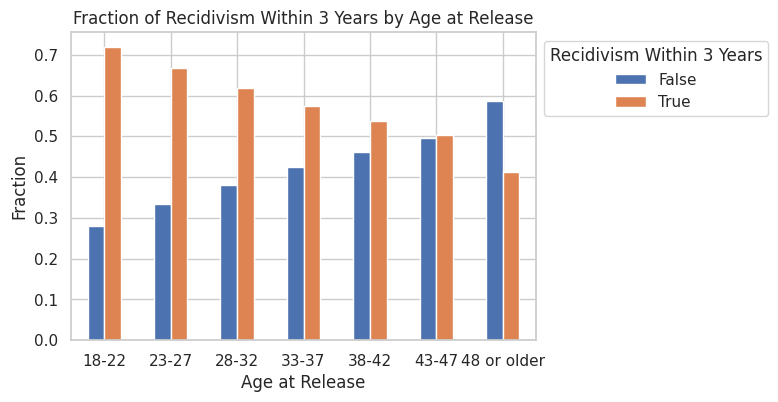

In [20]:
pd.crosstab(df['Age_at_Release'], df['Recidivism_Within_3years'], normalize='index').plot.bar(rot=0)
plt.title('Fraction of Recidivism Within 3 Years by Age at Release')
plt.xlabel('Age at Release')
plt.ylabel('Fraction');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.85),title="Recidivism Within 3 Years");

This bar plot displays the proportion of recidivism within three years across different age groups. Notably, the youngest age range, 18-22, exhibits the highest proportion of recidivism within 3 years and recidivism rate drops as the age gets higher. This indicates that younger parolees have a higher chance of being reconvicted within 3 years.

## Machine Learning

Machine Learning Data Preprocessing

In order to begin, we will drop all variables that are related to the outcome since our goal is to predict recidivism within 3 years.

In [21]:
df.drop(columns=['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt'], inplace=True)

We will need to change the values of some of the variables in the dataset to better suit our machine learning models.

In [22]:
df['Gender'].replace({'M': 0, 'F':1}, inplace=True)
df['Race'].replace({'BLACK': 0, 'WHITE':1}, inplace=True)
df['Gang_Affiliated'] = df['Gang_Affiliated'].replace({True:1, False:0})
df['Prior_Arrest_Episodes_DVCharges'] = (df['Prior_Arrest_Episodes_DVCharges'] == True).values.astype(int)
df['Prior_Arrest_Episodes_GunCharges'] = (df['Prior_Arrest_Episodes_GunCharges'] == True).values.astype(int)
df['Prior_Arrest_Episodes_GunCharges'] = (df['Prior_Arrest_Episodes_GunCharges'] == True).values.astype(int)
df['Prior_Conviction_Episodes_Viol'] = (df['Prior_Conviction_Episodes_Viol'] == True).values.astype(int)
df['Prior_Conviction_Episodes_PPViolationCharges'] = (df['Prior_Conviction_Episodes_PPViolationCharges'] == True).values.astype(int)
df['Prior_Conviction_Episodes_DomesticViolenceCharges'] = (df['Prior_Conviction_Episodes_DomesticViolenceCharges'] == True).values.astype(int)
df['Prior_Conviction_Episodes_GunCharges'] = (df['Prior_Conviction_Episodes_GunCharges'] == True).values.astype(int)
df['Violations_ElectronicMonitoring'] = (df['Violations_ElectronicMonitoring'] == True).values.astype(int)
df['Violations_Instruction'] = (df['Violations_Instruction'] == True).values.astype(int)
df['Violations_FailToReport'] = (df['Violations_FailToReport'] == True).values.astype(int)
df['Violations_MoveWithoutPermission'] = (df['Violations_MoveWithoutPermission'] == True).values.astype(int)

The variables we are changing here all have 2 different values (black/white, true/false, m/f) so we are changing those values to either 0 or 1.

In [23]:
df['Prison_Years'].replace({'1-2 years':0, 'Less than 1 year':1, 'More than 3 years':2, 'Greater than 2 to 3 years':3}, inplace=True)
df['Dependents'].replace({'0':0, '3 or more':3, '1':1, '2':2}, inplace=True)
df['Age_at_Release'].replace({'18-22': 0,'23-27':1,'28-32':2,'33-37':3,'38-42':4,'43-47':5,'48 or older': 6}, inplace=True)
df['Delinquency_Reports'].replace({'0':0, '1':1, '2':2, '3':3, '4 or more':4}, inplace=True)
df['Prison_Offense'].replace({'Property':0, 'Violent/Non-Sex':1, 'Drug':2, 'Unknown':3, 'Other':4, 'Violent/Sex':5}, inplace=True)
education = {'High School Diploma': 1, 'Less than HS diploma':2, 'At least some college':3}
df['Education_Level'].replace(education, inplace=True)
df['Residence_Changes'].replace({'0':0, '1':1, '2':2, '3 or more':3}, inplace=True)
df['Program_UnexcusedAbsences'].replace({'0':0, '1':1, '2':2, '3 or more':3}, inplace=True)
df['Program_Attendances'].replace({'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '9':9, '10 or more':10}, inplace=True)
df['Prior_Arrest_Episodes_Drug'].replace({'0':0, '1':1, '2':2, '3':3, '4':4,'5 or more':5}, inplace =True)
df['Prior_Arrest_Episodes_Felony'].replace({'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10 or more':10}, inplace=True)
df['Prior_Conviction_Episodes_Misd'].replace({'0': 0,'1':1,'2':2,'3':3, '4 or more':4}, inplace=True)
df['Prior_Conviction_Episodes_Prop'].replace({'0': 0,'1':1,'2':2,'3 or more':3}, inplace=True)
df['Prior_Arrest_Episodes_Misd'].replace({'0': 0,'1':1,'2':2, '3':3,'4':4, '5':5,'6 or more':6}, inplace=True)
df['Prior_Arrest_Episodes_Violent'].replace({'0': 0,'1':1,'2':2, '3 or more':3}, inplace=True)
df['Prior_Arrest_Episodes_Property'].replace({'0': 0,'1':1,'2':2, '3':3,'4':4,'5 or more':5}, inplace=True)
df['Prior_Arrest_Episodes_PPViolationCharges'].replace({'0': 0,'1':1,'2':2, '3':3,'4':4,'5 or more':5}, inplace=True)
df['Prior_Conviction_Episodes_Drug'].replace({'0': 0,'1':1,'2 or more':2}, inplace=True)
df['Prior_Conviction_Episodes_Felony'].replace({'0':0, '1':1, '2':2, '3 or more':3}, inplace=True)

These variables have multiple text values so we are changing those values to ordinal values of 0, 1, 2 ... , n values.

In [24]:
pd.get_dummies(df['Residence_PUMA'], drop_first=True)
pd.get_dummies(df['Prior_Revocations_Probation'], drop_first=True)
pd.get_dummies(df['Condition_MH_SA'], drop_first=True)
pd.get_dummies(df['Condition_Cog_Ed'],drop_first=True)
pd.get_dummies(df['Condition_Other'],drop_first=True)
pd.get_dummies(df['Prior_Revocations_Parole'], drop_first=True)
df['Supervision_Level_First'].replace({'Standard':0, 'Specialized':1, 'High':2, 'Not':3}, inplace=True)

Lastly we are filling the NA values in the data set with either an 'Unknown' value or to the median of the column.

Summary of DataFrame Information

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 42 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 18028 non-null  int64  
 1   Gender                                             18028 non-null  int64  
 2   Race                                               18028 non-null  int64  
 3   Age_at_Release                                     18028 non-null  int64  
 4   Residence_PUMA                                     18028 non-null  int64  
 5   Gang_Affiliated                                    18028 non-null  int64  
 6   Supervision_Risk_Score_First                       18028 non-null  float64
 7   Supervision_Level_First                            18028 non-null  int64  
 8   Education_Level                                    18028 non-null  int64  
 9   Depend

The DataFrame contains 18028 entries and 42 columns. The data types include integers, floats, booleans, and one object type. There are no missing values in any of the columns. The columns represent various features such as gender, race, age at release, prior arrest episodes, prior convictions, program attendances, and recidivism status within three years.

We can start defining our predictor variables. We will include all variables except the target variable as predictors.

In [26]:
predictors = ['Education_Level','Residence_Changes','Program_UnexcusedAbsences','Program_Attendances','Delinquency_Reports','Condition_Other', 'Condition_Cog_Ed','Condition_MH_SA', 'Prior_Revocations_Probation','Prior_Revocations_Parole', 'Prior_Conviction_Episodes_Felony', 'Supervision_Level_First','Age_at_Release', 'Violations_MoveWithoutPermission','Violations_FailToReport','Violations_Instruction','Violations_ElectronicMonitoring','Prison_Offense','Prior_Arrest_Episodes_GunCharges','Prior_Arrest_Episodes_DVCharges','Prior_Arrest_Episodes_PPViolationCharges','Prior_Arrest_Episodes_Property','Prior_Arrest_Episodes_Violent','Prior_Arrest_Episodes_Misd','Prior_Conviction_Episodes_GunCharges','Prior_Conviction_Episodes_DomesticViolenceCharges','Prior_Conviction_Episodes_PPViolationCharges','Prior_Conviction_Episodes_Prop','Prior_Conviction_Episodes_Viol','Prior_Conviction_Episodes_Drug','Prior_Arrest_Episodes_Felony','Prior_Conviction_Episodes_Misd','Prior_Arrest_Episodes_Drug', 'Supervision_Risk_Score_First', 'Gender', 'Race', 'Gang_Affiliated', 'Residence_PUMA','Dependents', 'Prison_Years']
target = 'Recidivism_Within_3years'

We are changing the values in our target variable to contain zeros and ones to prepare them for use with our machine learning algorithms.

In [27]:
X = df[predictors].values
y = (df[target] == True).values.astype(int)


We are creating a train/test split with 80% of the data being used for training and 20% of the data will be used for testing.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Before we continue developing our machine learning models, we will calculate the baseline accuracy. Ideally our machine learning models will give us a higher accuracy.

In [30]:
majority_class = pd.Series(y_train).value_counts().index[0]
accuracy_baseline = (majority_class == y_train).mean()
print(f"Baseline accuracy: {accuracy_baseline:.2f}")

Baseline accuracy: 0.57


For our first machine learning algorithm, we will start with a knn classifier. In order to use an ideal k, number of neighbors, we will use cross-validation.

In [31]:
cv_acc = []
ks = np.arange(1, 60, 5)
for k in ks:
  knn_cv = KNeighborsClassifier(n_neighbors=k)
  knn_cv.fit(X_train, y_train)
  score = cross_val_score(knn_cv, X_train, y_train, scoring='accuracy', cv=10).mean()
  cv_acc.append(score)

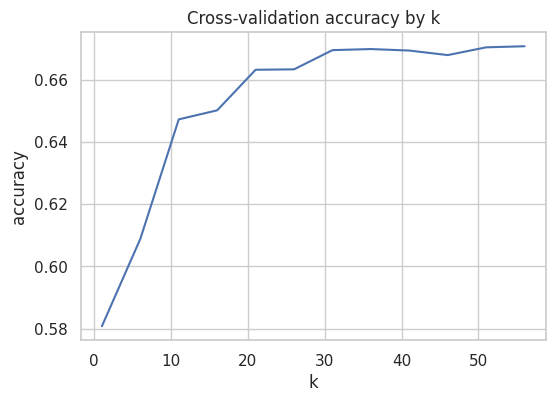

In [32]:
plt.plot(ks, cv_acc, label='cv')
plt.title('Cross-validation accuracy by k')
plt.xlabel('k')
plt.ylabel('accuracy');

This plot shows how the cross validation accuracy of the Knn Classifier changes with different values of k. As k increases, accuracy tends to increase as well. However, when k is approximately 46, the acccuracy is slightly lower. Once k reaches 51, the accuracy appears unchanged. The plot shows the highest accuracy is approximately 0.67.

In [33]:
knn = KNeighborsClassifier(n_neighbors=41)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=41)

In [34]:
accuracy = cross_val_score(knn,X_train, y_train).mean()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.67


### Logistic Regression

In [35]:
knn_logistic = LogisticRegression()
knn_logistic.fit(X_train, y_train)

LogisticRegression()

In [36]:
logistic_cv = cross_val_score(knn_logistic, X_train, y_train, cv=10, scoring='accuracy').mean()
print(f'CV accuracy: {logistic_cv:.2f}')

CV accuracy: 0.69


In [37]:
train_sizes, train_scores, test_scores = learning_curve(knn_logistic, X_train, y_train, cv=10, scoring='accuracy')
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)

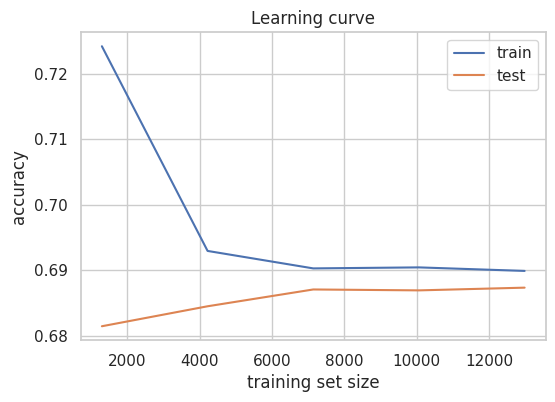

In [38]:
plt.plot(train_sizes, train_score_mean, label='train')
plt.plot(train_sizes, test_score_mean, label='test')
plt.title('Learning curve')
plt.xlabel('training set size')
plt.ylabel('accuracy')
plt.legend();

This learning curve represents high bias suggesting our model is overfitting. It is evident that more data will not improve our model. In fact, our model is already learning the training data with a great extent of detail. It is having a hard time capturing the overall shape of the data. In order to resolve this issue, we will use polynomial features.  

In [39]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [40]:
knn_logistic = LogisticRegression(penalty='l2', max_iter=1000)
knn_logistic.fit(X_train_poly, y_train)

LogisticRegression(max_iter=1000)

In [41]:
logistic_cv = cross_val_score(knn_logistic, X_train_poly, y_train, cv=10, scoring='accuracy').mean()
print(f'CV accuracy: {logistic_cv:.2f}')

CV accuracy: 0.68


In [42]:
train_sizes, train_scores, test_scores = learning_curve(knn_logistic, X_train_poly, y_train, cv=10, scoring='accuracy')
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)

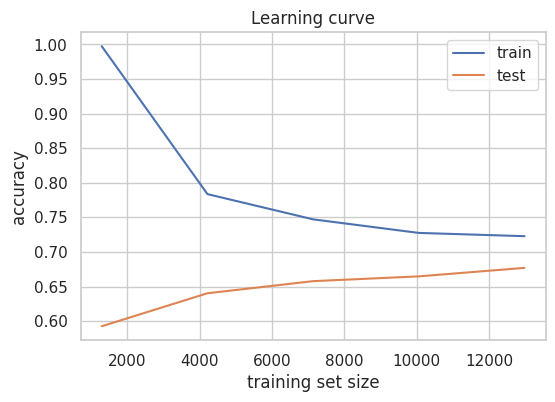

In [43]:
plt.plot(train_sizes, train_score_mean, label='train')
plt.plot(train_sizes, test_score_mean, label='test')
plt.title('Learning curve')
plt.xlabel('training set size')
plt.ylabel('accuracy')
plt.legend();

After adding polynomial features, our model demonstrates less overfitting. It appears to be better at capturing the main perspectives from the data than before. The model gives less weight to specific features and averages predictions better.  

### DecisionTree

Decision Tree

In [44]:
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

Here we are creating another machine learning model, a Decision Tree Classifier.

Cross-validation Accuracy Calculation

In [45]:
score_cv = cross_val_score(clf, X_train, y_train , cv=10).mean()
print(f'Cross-validation accuracy: {score_cv:.2f}')

Cross-validation accuracy: 0.65


Learning Curve Analysis for Classification Tree Model

In [46]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

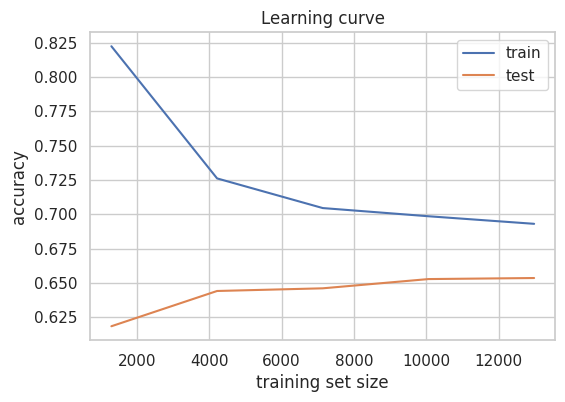

In [47]:
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.title('Learning curve')
plt.xlabel('training set size')
plt.ylabel('accuracy')
plt.legend();

The learning curve analysis for the classification tree model reveals a cross-validation accuracy of 0.65. However, the plotted learning curve indicates high variance, suggesting low overfitting. The model performs significantly better on the training data compared to testing data.

In [48]:
grid = {
    'max_depth': range(2, 16,2),
    'min_samples_leaf': [5, 10, 20 , 30],
    'max_features': ['sqrt', None]
}
clf = DecisionTreeClassifier()
tree_cv = GridSearchCV(clf, grid, cv=10)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 16, 2),
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [5, 10, 20, 30]})

In [49]:
print(tree_cv.best_params_)

{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 30}


In [50]:
print(f'Top accuracy from grid Search: {tree_cv.best_score_:.2f}')

Top accuracy from grid Search: 0.66


Hyperparameter Tuning for Decision Tree Classifier

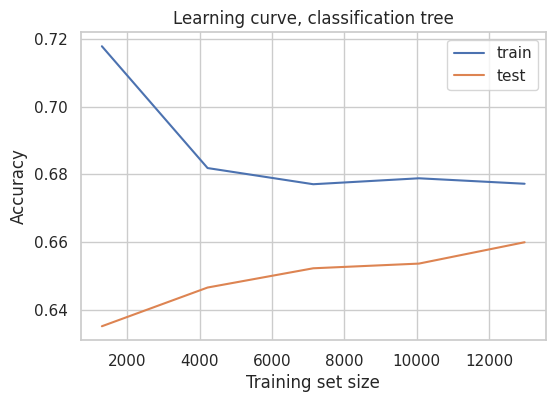

In [51]:
train_sizes, train_scores, test_scores = learning_curve(tree_cv.best_estimator_, X_train, y_train, cv =10)
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_score_mean, label = 'train')
plt.plot(train_sizes, test_score_mean, label='test')
plt.title('Learning curve, classification tree')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.legend();

The learning curve of a Decision Tree classifier demonstrates that the model  is exhibiting high variance, which might be due to overfitting.


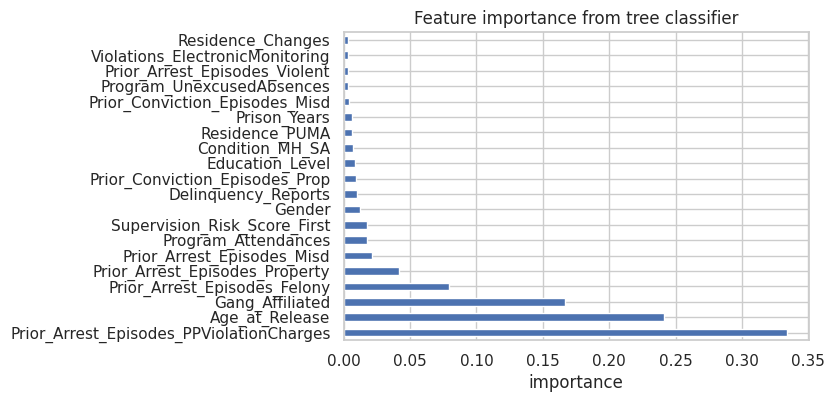

In [52]:
pd.Series(tree_cv.best_estimator_.feature_importances_, index=predictors).sort_values(ascending=False).nlargest(20).plot.barh(title="Feature importance from tree classifier")
plt.xlabel("importance");

This plot demonstrated the most important features by the level of importance. It appears that Prior_Arrest_Episodes_PPViolationCharges is the most important feature. Prior_Arrest_Episodes_PPViolationCharges is the number of prior arrests involving violation of probation or parole charges. Age_at_Release, and Gang_Affiliation are other major important features. Above Prior_Arrest_Espisodes_Felony, the level of importance appears to decrease.

KNN Classifier Test Results:

In [53]:
knn.fit(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)
print('Test accuracy: {:.2f}'.format(test_accuracy))

Test accuracy: 0.68


Logistic Regressor Test Results:

In [54]:
knn_logistic.fit(X_train,y_train)
score = knn_logistic.score(X_test,y_test)
print('Test accuracy: {:.2f}'.format(score))

Test accuracy: 0.68


Decision Tree Classifier Test Results:

In [55]:
score = tree_cv.best_estimator_.score(X_test,y_test)
print(f"test accuracy: {score.round(2)}")

test accuracy: 0.67


## Conclusions

After dropping columns with significant missing values and filling NA values with appropriate replacements, we successfully developed three distinct supervised machine learning models: a KNN classifier, a logistic regressor model, and a decision tree classifier. These models went through training using an 80% training data split. For all models, cross-validation was performed, with grid search utilized exclusively for the decision tree. The initial baseline accuracy score stood at 0.57, but all three of our machine learning models demonstrated higher results, indicating their effectiveness.
Notably, the KNN classifier demonstrated the highest test accuracy, achieving a score of 0.68, showing an improvement of 0.11. Following closely, the logistic regressor displayed a high score of 0.68 while also showing a slight improvement of 0.11.Both showing the same scores. Lastly, the decision tree classifier achieved a score of 0.67, showing an improvement of 0.10.
If another group were to look into achieving the same project. We recommend gathering more data in order to improve performance. A possible future improvement can be getting higher degrees in the polynomial feature. It would also be interesting to add complex machine learning algorithmns since they might perform better.